# Explore Simple QA

### Sources

Simple QA dataset downloaded from: https://www.dropbox.com/s/tohrsllcfy7rch4/SimpleQuestions_v2.tgz

FB5M names downloaded from: https://www.dropbox.com/s/yqbesl07hsw297w/FB5M.name.txt

### Experiments

- Question Consistency:
    - [ ] Hypothesis some questions do not fit the distribution. Look at the bottom 1% of questions that have unique tokens. We known double spaces or question marks are not consistent.
- Entity Detection
    - [x] Hypothesis is that the object to be detected is not found in the question. Figure out how many objects are not in the question.
    - [ ] Experiment with CRF and copy model for entity detection.
- Entity Linking
    - [x] Santity check that the true object is in FB5M.
    - [x] Santity check all MIDs have an associated english name.
    - [x] Hypothesis that objects have duplicates. Given the true object, measure how many duplicates need to be parsed through on the validation set. 
        - [ ] Hypothesis there are external features that help linking. Experiment with which features best predict the object.
            - [ ] Hypothesis is that type of the entity could help disambiguate duplicates.
- Relation Detection
    - [x] Hypothesis that some of the relations occur in dev and do not occur in train. Measure this affect.
        - [ ] Hypothesis that the unknown relations can be extrapolated from words. Check if some of the relation words are unknown.
        - [ ] Hypothesis that the unknown relations can be extrapolated from words. Check which levels 1, 2 or 3 are unknown in the relation.
        - [ ] Experiment with beam search for relations and word tokenization. Beam search will help us get the top 2 - 3 beams.
- Relation and Entity to Fact
    - [x] Santity check that FB5M has the facts corresponding to the answer given the true relation and the true entity.

In [43]:
simple_qa = {
    'train': '../../data/SimpleQuestions_v2/annotated_fb_data_train.txt',
    'dev': '../../data/SimpleQuestions_v2/annotated_fb_data_valid.txt',
    'test': '../../data/SimpleQuestions_v2/annotated_fb_data_test.txt',
}

## Santity: True Entity and True Relation map to True Subject

Ensure that the facts used to build the row are present in the FB5M dataset. This invariant must hold true.

In [44]:
import os
import psycopg2
import psycopg2.extras

# Load .env file
pass_ = {}
for line in open('../../.pass'):
    split = line.strip().split('=')
    pass_[split[0]] = split[1]

# Connect    
connection = psycopg2.connect(dbname=pass_['DB_NAME'],
                              port=pass_['DB_PORT'],
                              user=pass_['DB_USER'],
                              host=pass_['DB_HOST'],
                              password=pass_['DB_PASS'])
cursor = connection.cursor()

In [45]:
from IPython.display import display
import pandas as pd
from sklearn.utils import shuffle

df = pd.read_table(simple_qa['dev'], header=None, names=['subject', 'relation', 'object', 'question'])
df = shuffle(df, random_state=123)
display(df)

,subject,relation,object,question
6219,www.freebase.com/m/03k3r,www.freebase.com/biology/organism_classificati...,www.freebase.com/m/0bs56bp,Name an American Thoroughbread racehorse
3364,www.freebase.com/m/02qlppc,www.freebase.com/cvg/computer_videogame/cvg_genre,www.freebase.com/m/01sjng,what kind of game is vision racing driving sim...
9374,www.freebase.com/m/02l7c8,www.freebase.com/tv/tv_genre/programs,www.freebase.com/m/0dlmm88,what tv program is romance film
10142,www.freebase.com/m/049_zj3,www.freebase.com/location/location/containedby,www.freebase.com/m/04rrx,what state is polaski located in
97,www.freebase.com/m/02w9ycr,www.freebase.com/people/deceased_person/cause_...,www.freebase.com/m/0qcr0,what disease claimed the life of fern emmett
8296,www.freebase.com/m/08k_58,www.freebase.com/music/artist/album,www.freebase.com/m/02rw0hc,what is tristeza's album that starts with an s
3932,www.freebase.com/m/0dp76p7,www.freebase.com/music/album/artist,www.freebase.com/m/06twql,"who was the artist on the album just you, just me"
6960,www.freebase.com/m/06c6tz,www.freebase.com/ice_hockey/hockey_player/hock...,www.freebase.com/m/02qvdc,what position does max bentley play
2168,www.freebase.com/m/0d0gvn,www.freebase.com/computer/computer_processor/m...,www.freebase.com/m/03s7h,what company made intel core 2?
1893,www.freebase.com/m/05gg9s,www.freebase.com/cvg/computer_videogame/cvg_genre,www.freebase.com/m/06zm8z,what kind of game is the legend of zelda: twil...


In [46]:
from tqdm import tqdm_notebook

for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
    subject_mid = row['subject'].strip().replace('www.freebase.com/m/', '')
    relation = row['relation'].strip().replace('www.freebase.com/', '')
    object_mid = row['object'].strip().replace('www.freebase.com/m/', '')
    sql = """SELECT count(*) FROM fb_kg
             WHERE object_mid='{object_mid}'
             AND relation='{relation}'
             AND subject_mid='{subject_mid}'""".format(object_mid=object_mid,
                                                       relation=relation,
                                                       subject_mid=subject_mid)
    cursor.execute(sql)
    n_rows = cursor.fetchone()[0]
    if n_rows == 0:
        print('TUPLE NOT FOUND')
        print(sql)
print('Done!')

HBox(children=(IntProgress(value=0, max=10845), HTML(value='')))

TUPLE NOT FOUND
SELECT count(*) FROM fb_kg
             WHERE object_mid='07s9rl0'
             AND relation='film/film/genre'
             AND subject_mid='07gkcf'
TUPLE NOT FOUND
SELECT count(*) FROM fb_kg
             WHERE object_mid='0kg1cyw'
             AND relation='people/profession/people_with_this_profession'
             AND subject_mid='02h664x'

Done!


### Numbers

- Train, 25 facts in dev are not in FB5M
- Dev, 2 facts in dev are not in FB5M

## Hypothesis: Object Name not in Question

For every subject_mid, if there exists a name then that name may not be directly stated in the question. The only transformation applied is to lowercase due to the fact the freebase names are lowercased.

### Background

Knowledge Bases contain facts expressed as triples (subject, relationship, object), where subject and object are entities and relationship describes the type of (directed) link between these entities. The simple QA problem we address here consist in finding the answer to questions that can be rephrased as queries of the form (subject, relationship, ?), asking for all objects linked to subject by relationship.

The question What do Jamaican people speak ?, for instance, could be rephrased as the Freebase query (jamaica, language spoken, ?). In other words, fetching a single fact from a KB is sufficient to answer correctly.

Reference: https://research.fb.com/wp-content/uploads/2016/11/large-scale_simple_question_answering_with_memory_networks.pdf?

In [51]:
# Required for moses
# import nltk
# nltk.download('perluniprops')
# nltk.download('nonbreaking_prefixes')

import textwrap
from nltk.tokenize.treebank import TreebankWordTokenizer

tokenize = TreebankWordTokenizer().tokenize

def name_in_question(question, names):
    for name in names:
        if name in question:
            return name
    return None

count = 0
for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
    subject_mid = row['subject'].strip().replace('www.freebase.com/m/', '')
    question = row['question'].strip()
    question = ' '.join(tokenize(question.lower()))
    sql = """SELECT alias FROM fb_name
             WHERE mid='{mid}'""".format(mid=subject_mid)
    cursor.execute(sql)
    rows = cursor.fetchall()
    if len(rows) == 0:
        print('\nSubject MID do not have aliases.')
        continue
    names = [row[0].strip().lower() for row in rows]
    subject_name = name_in_question(question, names)
    if subject_name is None:
        print('\nNAME NOT IN QUESTION')
        print('ORG QUESTION:', row['question'])
        print('QUESTION:', question)
        print('NAMES:', names)
        print('MID:', subject_mid)
#         Print TABLE
#         count += 1
#         names = textwrap.shorten(', '.join(names), width=80, placeholder="...")
#         print('| ' + str(count) + ' | ' + question + ' | ' + subject_mid + ' | ' + names + ' | |')
    else:
        df.loc[index, 'subject_name'] = subject_name

print('DONE!')

HBox(children=(IntProgress(value=0, max=10845), HTML(value='')))


NAME NOT IN QUESTION
ORG QUESTION: what was involved in the red clouds war?
QUESTION: what was involved in the red clouds war ?
NAMES: ["red cloud 's war"]
MID: 02fjhv

NAME NOT IN QUESTION
ORG QUESTION: which Canadian city is served by e>
QUESTION: which canadian city is served by e >
NAMES: ['seychelles airport', 'seychelles international airport']
MID: 0359ld

NAME NOT IN QUESTION
ORG QUESTION: What is peters point plantation's architectural style
QUESTION: what is peters point plantation 's architectural style
NAMES: ["peter 's point plantation"]
MID: 06_l40z

NAME NOT IN QUESTION
ORG QUESTION: what film is rated pg
QUESTION: what film is rated pg
NAMES: ['pg ( usa )']
MID: 0kprc8

NAME NOT IN QUESTION
ORG QUESTION: what is an active ingredient in teething?
QUESTION: what is an active ingredient in teething ?
NAMES: ['tribasic calcium phosphate - matricaria recutita - arabica coffee bean 0.000214/0.000214/0.000214 pellet']
MID: 0hqv3wh

NAME NOT IN QUESTION
ORG QUESTION: What is t


NAME NOT IN QUESTION
ORG QUESTION: which person is marwaris
QUESTION: which person is marwaris
NAMES: ['marwari people']
MID: 04k02l

NAME NOT IN QUESTION
ORG QUESTION: what is a multiplayer computer video game
QUESTION: what is a multiplayer computer video game
NAMES: ['multiplayer video game']
MID: 01z747

NAME NOT IN QUESTION
ORG QUESTION: where did josefhassid die
QUESTION: where did josefhassid die
NAMES: ['josef hassid']
MID: 07r_2y

NAME NOT IN QUESTION
ORG QUESTION: How is the drug face it oil cut dual bb emulsion spf20 applied to body
QUESTION: how is the drug face it oil cut dual bb emulsion spf20 applied to body
NAMES: ['titanium dioxide 0.1 cream']
MID: 0hqs6nl

NAME NOT IN QUESTION
ORG QUESTION: What's a text based multiplayer game
QUESTION: what 's a text based multiplayer game
NAMES: ['multiplayer video game']
MID: 01z747

NAME NOT IN QUESTION
ORG QUESTION: what genre is crystal city
QUESTION: what genre is crystal city
NAMES: ['the crystal city']
MID: 05dz6m

NAME NOT 


NAME NOT IN QUESTION
ORG QUESTION: which religion does ustad atta mohammed noor practice
QUESTION: which religion does ustad atta mohammed noor practice
NAMES: ['atta muhammad nur']
MID: 05ts08

NAME NOT IN QUESTION
ORG QUESTION: Name a popular racing game for the Xbox.
QUESTION: name a popular racing game for the xbox .
NAMES: ['racing video game']
MID: 01sjng

NAME NOT IN QUESTION
ORG QUESTION: is zekes pad an action, romance, or comedy tv program
QUESTION: is zekes pad an action , romance , or comedy tv program
NAMES: ["zeke 's pad"]
MID: 09rs4y3

NAME NOT IN QUESTION
ORG QUESTION: what is the subject of whos an expert?
QUESTION: what is the subject of whos an expert ?
NAMES: ["who 's an expert"]
MID: 0s91pv3

NAME NOT IN QUESTION
ORG QUESTION: what is the legal status of kadian er 
QUESTION: what is the legal status of kadian er
NAMES: ['morphine sulfate 20 capsule']
MID: 0hqv2xw

NAME NOT IN QUESTION
ORG QUESTION: which biofluid can butanoic acid, 3-methyl- be found in
QUESTION: 


NAME NOT IN QUESTION
ORG QUESTION: what is the format of the release ella... of thee i swing?
QUESTION: what is the format of the release ella ... of thee i swing ?
NAMES: ['ella… of thee i swing']
MID: 0bf68q1

NAME NOT IN QUESTION
ORG QUESTION: What is a dosage form of coumadin
QUESTION: what is a dosage form of coumadin
NAMES: ['warfarin sodium 4 tablet']
MID: 0hqtqct

NAME NOT IN QUESTION
ORG QUESTION: Which country was the album 20 classics of the 80s released in?
QUESTION: which country was the album 20 classics of the 80s released in ?
NAMES: ["20 classics of the '80s"]
MID: 036sk3g

Object MID and Subject MID do not have aliases.

NAME NOT IN QUESTION
ORG QUESTION: which artist sang the song cant get enough
QUESTION: which artist sang the song cant get enough
NAMES: ['can’t get enough', "ca n't get enough"]
MID: 0llspl

NAME NOT IN QUESTION
ORG QUESTION: what country produced the film la stanza del vescovo
QUESTION: what country produced the film la stanza del vescovo
NAMES: [


NAME NOT IN QUESTION
ORG QUESTION: what is john mark karr's gender 
QUESTION: what is john mark karr 's gender
NAMES: ['alexis reich']
MID: 0g80_b

NAME NOT IN QUESTION
ORG QUESTION: What is bikash malal's nationality?
QUESTION: what is bikash malal 's nationality ?
NAMES: ['bikash malla']
MID: 0j37y7d

NAME NOT IN QUESTION
ORG QUESTION: What is the nationality of annrabson?
QUESTION: what is the nationality of annrabson ?
NAMES: ['rabson , ann', 'ann rabson']
MID: 0dpznr

NAME NOT IN QUESTION
ORG QUESTION: which country is cowichan lake in
QUESTION: which country is cowichan lake in
NAMES: ['lake cowichan , british columbia', 'lake cowichan , canada', 'lake cowichan']
MID: 05t592

Object MID and Subject MID do not have aliases.

NAME NOT IN QUESTION
ORG QUESTION: What is william e. mcanulty, jr.'s gender
QUESTION: what is william e. mcanulty , jr. 's gender
NAMES: ['william mcanulty , jr.', 'william e. mcanulty jr.']
MID: 02z0b5x

NAME NOT IN QUESTION
ORG QUESTION: What is an active 


NAME NOT IN QUESTION
ORG QUESTION: what is the release type of live at sweet basil, volume 2
QUESTION: what is the release type of live at sweet basil , volume 2
NAMES: ['live at sweet basil volume 2', "live at `` sweet basil '' , volume 2"]
MID: 03jj2rm

NAME NOT IN QUESTION
ORG QUESTION: who is german?
QUESTION: who is german ?
NAMES: ['german people', 'germans']
MID: 013xrm

Object MID and Subject MID do not have aliases.

NAME NOT IN QUESTION
ORG QUESTION: what kind of film is mockingbird dont sing
QUESTION: what kind of film is mockingbird dont sing
NAMES: ["mockingbird do n't sing"]
MID: 04lm64

NAME NOT IN QUESTION
ORG QUESTION: which war did the heatons crossroads take place
QUESTION: which war did the heatons crossroads take place
NAMES: ['purcellville wagon raid', 'skirmishes near wood grove and purcellville', "heaton 's crossroads"]
MID: 03d0lfr

NAME NOT IN QUESTION
ORG QUESTION: What release is evolution a part of?
QUESTION: what release is evolution a part of ?
NAMES: ['


NAME NOT IN QUESTION
ORG QUESTION: what type of music is godthelux
QUESTION: what type of music is godthelux
NAMES: ['vesania']
MID: 01r9kbp

Object MID and Subject MID do not have aliases.

NAME NOT IN QUESTION
ORG QUESTION: which active ingredient is found in loxapine succinate
QUESTION: which active ingredient is found in loxapine succinate
NAMES: ['loxapine succinate 5 capsule']
MID: 0hqsnv2

NAME NOT IN QUESTION
ORG QUESTION: what is the name of a video game of the beat em up collection
QUESTION: what is the name of a video game of the beat em up collection
NAMES: ["beat 'em up"]
MID: 09l27d

NAME NOT IN QUESTION
ORG QUESTION: robrock1 plays what instrument
QUESTION: robrock1 plays what instrument
NAMES: ['rock , rob', 'rob rock']
MID: 095tsw

NAME NOT IN QUESTION
ORG QUESTION: what country is the tv program originally from 
QUESTION: what country is the tv program originally from
NAMES: ['the 7pm project', 'the 7pm project ratings', 'the project', 'the project']
MID: 0660fc9

Ob


Object MID and Subject MID do not have aliases.

NAME NOT IN QUESTION
ORG QUESTION: what's an active ingredient in anal itch ease
QUESTION: what 's an active ingredient in anal itch ease
NAMES: ['fagopyrum , croton , aesculus , sulphur , kali sulph , cina 0.36/0.18/0.36/0.18/0.18/0.36 tincture']
MID: 0hqtfb2

NAME NOT IN QUESTION
ORG QUESTION: What was theatrical production of MacBeth staged in?
QUESTION: what was theatrical production of macbeth staged in ?
NAMES: ['donmar', 'donmar warehouse , london borough of camden', 'donmar warehouse']
MID: 04rltj

NAME NOT IN QUESTION
ORG QUESTION: what is drug has trophamine as an active ingredient 
QUESTION: what is drug has trophamine as an active ingredient
NAMES: ['alanine , arginine , aspartic acid , cysteine hydrochloride , glutamic acid , glycine , histidine , isoleucine , leucine , lysine acetate , methionine , n-acetyl-tyrosine , phenylalanine , proline , serine , taurine , threonine , tryptophan , tyrosine , and valine 5.4/12/3.2/0.2


NAME NOT IN QUESTION
ORG QUESTION: What is a game with single-player mode?
QUESTION: what is a game with single-player mode ?
NAMES: ['single-player video game']
MID: 02hjn4

NAME NOT IN QUESTION
ORG QUESTION: what is the key component of loma lux psoriasis
QUESTION: what is the key component of loma lux psoriasis
NAMES: ['nickel sulfate hexahydrate , potassium bromide , potassium sulfate , sodium bromide , and zinc bromide 3/1/4/2/4 liquid']
MID: 0hqshpf

Object MID and Subject MID do not have aliases.

NAME NOT IN QUESTION
ORG QUESTION: Who wrote the emperors new cloak
QUESTION: who wrote the emperors new cloak
NAMES: ["the emperor 's new cloak"]
MID: 0997yx

NAME NOT IN QUESTION
ORG QUESTION: who is the main artist of the album ?
QUESTION: who is the main artist of the album ?
NAMES: ['charlie parker & miles davis']
MID: 0sl6s7p

NAME NOT IN QUESTION
ORG QUESTION: what type of music does make?
QUESTION: what type of music does make ?
NAMES: ['mulligan', 'john mulligan']
MID: 0281wv


NAME NOT IN QUESTION
ORG QUESTION: who was the publisher that released star wars: episode i: battle for naboo 
QUESTION: who was the publisher that released star wars : episode i : battle for naboo
NAMES: ['star wars : episode i - battle for naboo', 'star wars episode i : battle for naboo']
MID: 06fdwk

NAME NOT IN QUESTION
ORG QUESTION: Who was the editor of the book monster.
QUESTION: who was the editor of the book monster .
NAMES: ['monster.']
MID: 04vj5nl

NAME NOT IN QUESTION
ORG QUESTION: What country is Mount Grant in South Georgia located?
QUESTION: what country is mount grant in south georgia located ?
NAMES: ['grant mountain', 'mount grant , south georgia']
MID: 02r42ly

NAME NOT IN QUESTION
ORG QUESTION: what kind of album is ....on the radio
QUESTION: what kind of album is ... .on the radio
NAMES: ['... .on the radio / turn off the light', '... on the radio ( remember the days )', 'on the radio ( remember the days )', 'shit on the radio', '... .on the radio / turn off the 


NAME NOT IN QUESTION
ORG QUESTION: what kind of album is raffis christmas album
QUESTION: what kind of album is raffis christmas album
NAMES: ["raffi 's christmas album"]
MID: 01l5yxq

NAME NOT IN QUESTION
ORG QUESTION: who is the composer of when you're alone
QUESTION: who is the composer of when you 're alone
NAMES: ['when you’re alone']
MID: 0_jl_y1

NAME NOT IN QUESTION
ORG QUESTION: What ingredient is dentree a formulation of
QUESTION: what ingredient is dentree a formulation of
NAMES: ['sodium fluoride 0.22 dentifrice gel']
MID: 0jxj2hz

NAME NOT IN QUESTION
ORG QUESTION: What kind of film is wallace and gromits cracking contraptions?
QUESTION: what kind of film is wallace and gromits cracking contraptions ?
NAMES: ["wallace and gromit 's cracking contraptions"]
MID: 08t9wc

NAME NOT IN QUESTION
ORG QUESTION: what is the type of release of screwed: al goldsteins kingdom of porn?
QUESTION: what is the type of release of screwed : al goldsteins kingdom of porn ?
NAMES: ["screwed :

### Numbers

- Dev, 398 ~ 3.97% questions do not contain subject name
    - Based on error bucket below this number can be decreased 68% to 127 
- Dev, 68 ~ .63% subject mids do have an alias

### Error Bucket

| Index | Question | Subject MID | Names | Bucket |
|:-----:|:-----:|:-----:|:-----:|:-----:|
| 1 | what was involved in the red clouds war ? | 02fjhv | red cloud 's war | Apostrophe |
| 2 | which canadian city is served by e > | 0359ld | seychelles airport, seychelles international airport | Missing Name |
| 3 | what is peters point plantation 's architectural style | 06_l40z | peter 's point plantation | Apostrophe |
| 4 | what film is rated pg | 0kprc8 | pg ( usa ) | Parentheses |
| 5 | what is an active ingredient in teething ? | 0hqv3wh | tribasic calcium phosphate - matricaria recutita - arabica coffee bean... | Missing Name |
| 6 | what is the name of the track list for the release pillows & prayers : cherry red 1982-1983 ? | 0f3hh9h | pillows & prayers : cherry red 1982–1983 | Dash |
| 7 | what is the birth place of james aiona | 02_ks3 | duke aiona | Missing Name |
| 8 | what kind of music is fragmentsofunbecoming known for ? | 0g92n_ | fragments of unbecoming, fragments of unbecoming | Concatenated |
| 9 | where was kristythirsk born | 01phhd5 | thirsk , kristy, kristy thirsk | Concatenated |
| 10 | where did the battle of hudsons bay take place | 0cyg9y | battle of hudson 's bay | Apostrophe |
| 11 | which country originally showed e.n.g . | 055y4f | e.n.g. | Abbreviation |
| 12 | what is ikkyu 's gender ? | 03gccd | ikkyū | Accent & Apostrophe |
| 13 | who is the composer of another horsedreamer ’ s blues | 0zlxj1z | another horsedreamer’s blues | Apostrophe |
| 14 | name a topical medicine | 03jy9d | topical medication | Synonym |
| 15 | what baseball position does play | 02qbjc3 | mike stefanski | Missing Name |
| 16 | what newspaper circulates in the town of kearny | 013kcv | t-town, tulsa , oklahoma, wagoner county / tulsa city, tulsa | Missing Name |
| 17 | what is a japanese netflix movie | 0gw5n2f | japanese movies | Missing Name |
| 18 | which military conflict was cincinnatus involved in ? | 017tcg | lucius quinctius cincinnatus | Partial Match |
| 19 | which musician plays the drum kit | 02hnl | drum set, drummer, drums & cymbals, drumset, rumpusetti, drums | Synonym |
| 20 | what state is dimillos floating restaurant in ? | 0ddb60x | dimillo 's floating restaurant | Apostrophe |
| 21 | what is tinsleyellis 's profession ? | 01nzbnm | ellis , tinsley, tnsley ellis, tinsley ellis | Concatenated |
| 22 | who produces npr : wait wait ... dont tell me ! podcast | 041z1gp | npr : wait wait ... do n't tell me !, wait wait ... do n't tell me !, wait... | Apostrophe |
| 23 | what instrument does ralphsantolla play | 0fjz2n | santolla , ralph, ralph santolla | Concatenated |
| 24 | what theme is in the piece regatta mystery | 0b55z6 | the regatta mystery | Article ~ "the" |
| 25 | what genre of music does houseofpleasure make | 09hntw | plan b | Missing Name |
| 26 | what is the formulation of clear defense hand sanitizing wipes | 0hqtqnf | alcohol 3.32 cloth | Missing Name |
| 27 | what is the birth place of charles a. pascal , jr . | 0853_8 | charles pascal , jr., charles a. pascal , jr. | Period |
| 28 | name a racing game | 01sjng | racing video game | Partial Match |
| 29 | what is álvaro dataide da gama | 0lt7d9h | álvaro d'ataide da gama | Apostrophe |
| 30 | what song is by u.n.p.o.c . | 01qhzks | unpoc, u.n.p.o.c. | Abbreviation |
| 31 | name a census-designated place | 0qq4b | navajo county / pinon cdp, pinon , arizona, piñon , arizona, piñon | Missing Name |
| 32 | what ethnicity is jermaine jackson ? | 0x67 | africian-american, afro-american, black, black american, african american | Missing Name |
| 33 | what is the series where the episode this puds for you comes from | 05dfxn4 | this pud 's for you | Apostrophe |
| 34 | what genre is kazz kumar 's music ? | 064t9 | pop, pop music | Missing Name |
| 35 | where was now thats what i call music ! 28 released ? | 049k9qr | now that 's what i call music ! 28 | Apostrophe |
| 36 | how is the drug nefazodone hydrochloride administered | 0hqtdkp | nefazodone hydrochloride 50 tablet | Partial Match |
| 37 | who sings chets speech , part ii | 0lqg4r | chet 's speech , part 2, chet 's speech , part ii | Apostrophe |
| 38 | which ingredient is used in fungicure manicure pedicure | 0hqs33g | clotrimazole 10 liquid | Missing Name |
| 39 | what is the legal status of tylenol cold sore throat extra strength ? | 0hqv2b2 | acetaminophen 33.333 liquid | Missing Name |
| 40 | what genre music does andre sutherland do ? | 0cmbjx3 | poppy, popcaan | Missing Name |
| 41 | what is the active component of ob metab | 0hqs_sg | fucus vesiculosus , capsicum annuum , nicotinamidum , spongia tosta ,... | Missing Name |
| 42 | what country filmed vla lcinéma ou le roman de charles pathé | 0fpwzjl | the life of charles pathé, v'la l'cinéma ou le roman de charles pathé | Apostrophe |
| 43 | what is the composition form of pop ’ s love suicide | 0_hvt9g | pop’s love suicide | Apostrophe |
| 44 | what olympic games featured mens pommel horse | 04fk2x7 | men 's pommel horse | Apostrophe |
| 45 | which person is marwaris | 04k02l | marwari people | Partial Match |
| 46 | what is a multiplayer computer video game | 01z747 | multiplayer video game | Not Sequential |
| 47 | where did josefhassid die | 07r_2y | josef hassid | Concatenated |
| 48 | how is the drug face it oil cut dual bb emulsion spf20 applied to body | 0hqs6nl | titanium dioxide 0.1 cream | Missing Name |
| 49 | what 's a text based multiplayer game | 01z747 | multiplayer video game | Partial Match |
| 50 | what genre is crystal city | 05dz6m | the crystal city | Article ~ the |

## Explore: Object Name Duplicates without Relation

For each object name, if we predict it, are we able to link it to the MID without assistance? 

In [56]:
from tqdm import tqdm_notebook
import statistics
n_rows = df.shape[0]


dups = []
for index, row in tqdm_notebook(df.iterrows(), total=n_rows):
    if not pd.isnull(row['subject_name']):
        subject_name = row['subject_name']
        relation = row['relation'].strip().replace('www.freebase.com/', '')
        cursor.execute("""SELECT count(DISTINCT mid)
                          FROM fb_kg
                          LEFT JOIN fb_name
                          ON subject_mid = mid
                          WHERE alias LIKE %s""", (subject_name,))
        n_dups = cursor.fetchone()[0]
        dups.append(n_dups)
print('DONE!')
print('Median:', statistics.median(dups))
print('Mean:', statistics.mean(dups))
print('Stdev:', statistics.stdev(dups))
print('No Dups:', sum([1 for n in dups if n == 1]))
print('> 9 Dups:', sum([1 for n in dups if n > 9]))

HBox(children=(IntProgress(value=0, max=10845), HTML(value='')))


DONE!
Median: 1
Mean: 54.792947297427496
Stdev: 260.91925676565364
No Dups: 6155
> 9 Dups: 1756


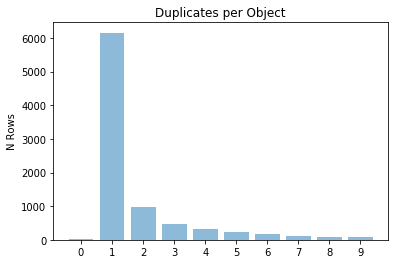

In [57]:
from collections import defaultdict 

import matplotlib.pyplot as plt;
import numpy as np
import matplotlib.pyplot as plt

buckets = defaultdict(int)
for n_dup in dups:
    buckets[n_dup] += 1

x = np.arange(10)
y = [buckets[val] for val in x]
 
plt.bar(x, y, align='center', alpha=0.5)
plt.xticks(x, x)
plt.ylabel('N Rows')
plt.title('Duplicates per Object')
plt.show()

### Numbers

Given we do not know the relation:
- Median Number of Duplicates: 1.0
- Mean Number of Duplicates: 54.792947297427496
- Stdev Number of Duplicates: 260.91925676565364
- No Duplicates: 6155 ~ 56.7%
- \> 9 Number of Duplicates: 1756

Given we know the relation:
- Median Number of Duplicates: 1.0
- Mean Number of Duplicates: 16.98626848473209
- Stdev Number of Duplicates: 87.08467913123698
- No Duplicates: 8527 ~ 78.6%
- \> 9 Number of Duplicates: 641

### Discussion

Given the correct relation, the duplicate problem affects 21.37% of rows. The largest bottle neck in the end-to-end system. 

## Explore: Dev Relation not in Train

Hypothesis that there are unknown relations in the dev set. They are not seen during train time.

In [58]:
df_train = pd.read_table(simple_qa['train'], header=None, names=['subject', 'relation', 'object', 'question'])
train_freq = defaultdict(int)
for index, row in tqdm_notebook(df_train.iterrows(), total=df_train.shape[0]):
    train_freq[row['relation']] += 1
print('Number of unique relations:', len(train_freq))
print('Sample:', list(train_freq.items())[:5])

HBox(children=(IntProgress(value=0, max=75910), HTML(value='')))


Number of unique relations: 1629
Sample: [('www.freebase.com/book/written_work/subjects', 1092), ('www.freebase.com/music/release_track/release', 676), ('www.freebase.com/film/film/country', 1374), ('www.freebase.com/music/producer/tracks_produced', 115), ('www.freebase.com/music/release/producers', 62)]


In [59]:
unseen = 0
for index, row in tqdm_notebook(df.iterrows(), total=n_rows):
    if row['relation'] not in train_freq:
        unseen += 1
print('Number of rows with unseen relations:', unseen)

HBox(children=(IntProgress(value=0, max=10845), HTML(value='')))


Number of rows with unseen relations: 71


In [61]:
infrequent = 0
for index, row in tqdm_notebook(df.iterrows(), total=n_rows):
    if row['relation'] not in train_freq or train_freq[row['relation']] < 30:
        infrequent += 1
print('Number of rows with infrequent relations:', infrequent)

HBox(children=(IntProgress(value=0, max=10845), HTML(value='')))


Number of rows with infrequent relations: 905


### Numbers

Rows with unseen relations in train:
- Dev has 71 rows with unseen relations
- Dev has 257 rows with relations seen less than 5 times
- Dev has 905 ~ 8.4% rows with relations seen less than 30 times

### Discussion

91.6% of the time the relation in the development set has had over 30 examples; therefore, the bottleneck is not in unseen relationships.